In [1]:
import pandas as pd
import numpy as np
import csv
import warnings

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.cross_validation import cross_val_score
from sklearn import naive_bayes

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# from tqdm import tqdm, tqdm_pandas
# tqdm.pandas()

import matplotlib.pyplot as plt


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# Frontmatter: 
grit_headers = 'data_folder/header_renames.rtf'
grit_data = 'data_folder/data.csv'

random_state = 42
fig_size = (10, 7)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
def get_label_personality_grit_data(csv_path, headers_path):
    
    """
    Load dataset from file and reconfigure headers

    :param csv_path: Path to the .csv file 
    :type csv_path: str

    :param headers_path: Path to the .rtf file of headers for the dataframe 
    :type headers_path: str

    :return: Returns a dataframe of the personality and grit and demographic data with columns labeled by the question which was asked.  
    :rtype: pandas.core.frame.DataFrame
    """

    df = pd.read_csv(csv_path,sep = "\t")

    # Some formatting of the headers file
    with open(headers_path) as f:
        rows = [line.split('\t') for line in f]
        headers_reformatted = { row[0]:row[-1] for row in rows }
    headers_reformatted.update({i: headers_reformatted[i][:-2] for i in headers_reformatted})
    
    # Rename dataframe columns based on the headers file
    df.rename(columns = headers_reformatted, inplace = True)

    #df["country"] = df[["country","operatingsystem","browser"]].astype('category')
    #df["operatingsystem"] = df["operatingsystem"].astype('category')
    #df["browser"] = df["browser"].astype('category')

    # If we wish to see an entire row of data we uncomment this. 
    '''
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_rows', 500)
    print (df.iloc[2])
    '''
    return df


In [4]:
def separate_data(data_frame, outcome_parameter):
    
    """
    Separates features from classifier, scales features, performs test/train split and returns split data

    :param data_frame: The complete dataframe 
    :type csv_path: pandas.core.frame.DataFrame


    :return: Returns dataframes of features for training and test, and corresponding classifier sets for training and test
    :rtype: (DataFrame, DataFrame, Series, Series)
    """
    
    y = data_frame[outcome_parameter]
    X = data_frame.drop(['religion',"country","operatingsystem","browser", 'surveyelapse',outcome_parameter], axis=1)
    X = scale(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random_state)
    return (X_train, X_test, y_train, y_test)

In [8]:
def preprocessing(df = df):
    """
    Takes in a dataframe of big-5 personality data, runs validity checks, aggregates participants' answers into personality and grit scores. 
    
    :param df: Path to the .rtf file of headers for the dataframe 
    :type df: pandas.core.frame.DataFrame

    :return: Returns a dataframe of the personality and grit and demographic with columns for the big5 personality types and for grit
    :rtype: pandas.core.frame.DataFrame
    
    """
    df['validity_check'] = df.apply(lambda row: row.florted + row.verdid + row.cuivocal, axis=1)
    df['language_check'] = df.apply(lambda row: row.boat + row.incoherent + row.pallid + row.robot + row.audible + row.paucity + row.epistemology + row.decide + row.pastiche + row.abysmal + row.lucid + row.betray + row.funn, axis=1)
    df = df[df.validity_check < 2] # If the subjects messed up two of the validity measures then exclude their data from the dataset.  
    df = df[df.language_check > 4] # If the subjects speak english very poorly (or got 0 because they weren't trying) then it may be worth excluding them as they likely didn't understand all the questions.  
    df = df[df.surveyelapse < 2000] # If the subjects speak english very poorly (or got 0 because they weren't trying) then it may be worth excluding them as they likely didn't understand all the questions.  
    df = df[df.age < 100] # There are a couple of subjects who claim to be 350 years old...we'll drop them too.    
    df = df[df.hand > 0] # there are some subjects who failed to answer this question 
    df = df[df.gender > 0] # gender = 0 was not a survey option but 5 results show it...removing these.      
    df = df[df.engnat > 0]       
    df = df[df.urban > 0]       
    df = df[df.married > 0]    
    df = df[df.voted > 0]   
    df = df[df.education > 0]     
    df = df.drop(['validity_check','language_check'], axis=1)

    # Separate out the categorical variables 
    dummies_df = pd.get_dummies(df['gender'])
    dummies_df = dummies_df.rename(columns={1: 'Male', 2: 'Female', 3: 'Other'})
    df = pd.concat([df, dummies_df], axis=1);
    
    dummies_df = pd.get_dummies(df['hand'])
    dummies_df = dummies_df.rename(columns={1: 'Right', 2: 'Left', 3: 'Both'})
    df = pd.concat([df, dummies_df], axis=1);
    
    df['orientation'] = df.apply(lambda row: 5 if row['orientation'] == 0 else row['orientation'],axis=1)
    dummies_df = pd.get_dummies(df['orientation'])
    dummies_df = dummies_df.rename(columns={1: 'Heterosexual', 2: 'Bisexual', 3: 'Homosexual', 4: 'Asexual', 5: 'Other'})
    df = pd.concat([df, dummies_df], axis=1);
    
    df['religion'] = df.apply(lambda row: 12 if row['religion'] == 0 else row['religion'],axis=1)
    dummies_df = pd.get_dummies(df['religion'])
    dummies_df = dummies_df.rename(columns={1: 'Agnostic', 2: 'Atheist', 3: 'Buddhist', 4: 'Catholic', 5: 'Mormon', 6: 'Protestant', 7: 'Other Christian', 8: 'Hindu', 9: 'Jewish', 10: 'Muslim', 11: 'Sikh', 12: 'Other'})
    df = pd.concat([df, dummies_df], axis=1);
        
    dummies_df = pd.get_dummies(df['urban'])
    dummies_df = dummies_df.rename(columns={1: 'Rural', 2: 'Suburban', 3: 'Urban'})
    df = pd.concat([df, dummies_df], axis=1);

    dummies_df = pd.get_dummies(df['married'])
    dummies_df = dummies_df.rename(columns={1: 'Never married', 2: 'Currently married', 3: 'Previously married'})
    df = pd.concat([df, dummies_df], axis=1);

    dummies_df = pd.get_dummies(df['voted'])
    dummies_df = dummies_df.rename(columns={1: 'Voted_Yes', 2: 'Voted_No'})
    df = pd.concat([df, dummies_df], axis=1);

    df['race'] = df.apply(lambda row: 5 if row['race'] == 0 else row['race'],axis=1)
    dummies_df = pd.get_dummies(df['race'])
    dummies_df = dummies_df.rename(columns={1: 'Asian', 2: 'Arab', 3: 'Black', 4: 'Indigenous Australian, Native American or White', 5: 'Other'})
    df = pd.concat([df, dummies_df], axis=1);
    
    dummies_df = pd.get_dummies(df['engnat'])
    dummies_df = dummies_df.rename(columns={1: 'engnat_yes', 2: 'engnat_no'})
    df = pd.concat([df, dummies_df], axis=1);
    
    
    df = df.drop(['gender', 'hand', 'orientation', 'engnat', 'race', 'married', 'urban', 'religion', 'voted ', 'familysize', 'testelapse', 'introelapse', 'screenh', 'screenw', 'age'], axis=1)
    
    # Let's get all the likert scales centered at 0
    likert_columns = [
            # Grit
           'I_have_overcome_setbacks_to_conquer_an_important_challenge_',
           'New_ideas_and_projects_sometimes_distract_me_from_previous_ones',
           'My_interests_change_from_year_to_year',
           'Setbacks_dont_discourage_me',
           'I_have_been_obsessed_with_a_certain_idea_or_project_for_a_short_time_but_later_lost_interest',
           'I_am_a_hard_worker_',
           'I_often_set_a_goal_but_later_choose_to_pursue_a_different_one',
           'I_have_difficulty_maintaining_my_focus_on_projects_that_take_more_than_a_few_months_to_complete',
           'I_finish_whatever_I_begin',
           'I_have_achieved_a_goal_that_took_years_of_work',
           'I_become_interested_in_new_pursuits_every_few_months', 'I_am_diligent',

            # Extraversion
           'I_am_the_life_of_the_party',
           'I_dont_talk_a_lot', 'I_feel_comfortable_around_people',
           'I_keep_in_the_background', 'I_start_conversations',
           'I_have_little_to_say',
           'I_talk_to_a_lot_of_different_people_at_parties',
           'I_dont_like_to_draw_attention_to_myself',
           'I_dont_mind_being_the_center_of_attention',
           'I_am_quiet_around_strangers', 

            # Neuroticism
            'I_get_stressed_out_easily',
           'I_am_relaxed_most_of_the_time', 'I_worry_about_things',
           'I_seldom_feel_blue', 'I_am_easily_disturbed', 'I_get_upset_easily',
           'I_change_my_mood_a_lot', 'I_have_frequent_mood_swings',
           'I_get_irritated_easily', 'I_often_feel_blue',

            # Agreeableness
           'I_feel_little_concern_for_others', 'I_am_interested_in_people',
           'I_insult_people', 'I_sympathize_with_others_feelings',
           'I_am_not_interested_in_other_peoples_problems', 'I_have_a_soft_heart',
           'I_am_not_really_interested_in_others', 'I_take_time_out_for_others',
           'I_feel_others_emotions', 'I_make_people_feel_at_ease',

            # Conscientiousness
           'I_am_always_prepared', 'I_leave_my_belongings_around',
           'I_pay_attention_to_details', 'I_make_a_mess_of_things',
           'I_get_chores_done_right_away',
           'I_often_forget_to_put_things_back_in_their_proper_place',
           'I_like_order', 'I_shirk_my_duties', 'I_follow_a_schedule',
           'I_am_exacting_in_my_work', 

            # Openness
            'I_have_a_rich_vocabulary',
           'I_have_difficulty_understanding_abstract_ideas',
           'I_have_a_vivid_imagination', 'I_am_not_interested_in_abstract_ideas',
           'I_have_excellent_ideas', 'I_do_not_have_a_good_imagination',
           'I_am_quick_to_understand_things', 'I_use_difficult_words',
           'I_spend_time_reflecting_on_things', 'I_am_full_of_ideas',
            ]

    for column in likert_columns:
        df[column] = df[column].apply(lambda x: x - 3) # We're zeroing out all the likert scale columns

    # Code all the indiivdual factors in the big 5 and GRIT scales into their aggregate scores.  
    df['Extroversion'] = df.apply(lambda row: (row.I_am_the_life_of_the_party
                                  + row.I_feel_comfortable_around_people 
                                  - row.I_keep_in_the_background
                                  + row.I_start_conversations
                                  - row.I_have_little_to_say
                                  + row.I_talk_to_a_lot_of_different_people_at_parties 
                                  - row.I_dont_like_to_draw_attention_to_myself
                                  + row.I_dont_mind_being_the_center_of_attention
                                  - row.I_am_quiet_around_strangers
                                  - row.I_dont_talk_a_lot)/10,
                                  axis=1)

    df['Neuroticism'] = df.apply(lambda row: (row.I_get_stressed_out_easily
                                  - row.I_am_relaxed_most_of_the_time 
                                  + row.I_worry_about_things
                                  - row.I_seldom_feel_blue
                                  + row.I_am_easily_disturbed
                                  + row.I_get_upset_easily 
                                  + row.I_change_my_mood_a_lot
                                  + row.I_have_frequent_mood_swings
                                  + row.I_get_irritated_easily
                                  + row.I_often_feel_blue)/10,
                                  axis=1)        

    df['Agreeableness'] = df.apply(lambda row: (row.I_am_interested_in_people
                                  - row.I_feel_little_concern_for_others
                                  - row.I_insult_people
                                  + row.I_sympathize_with_others_feelings
                                  - row.I_am_not_interested_in_other_peoples_problems
                                  + row.I_have_a_soft_heart 
                                  - row.I_am_not_really_interested_in_others
                                  + row.I_take_time_out_for_others
                                  + row.I_feel_others_emotions
                                  + row.I_make_people_feel_at_ease)/10,
                                  axis=1)    

    df['Conscientiousness'] = df.apply(lambda row: (row.I_am_always_prepared
                                  - row.I_leave_my_belongings_around 
                                  + row.I_pay_attention_to_details
                                  - row.I_make_a_mess_of_things
                                  + row.I_get_chores_done_right_away
                                  - row.I_often_forget_to_put_things_back_in_their_proper_place 
                                  + row.I_like_order
                                  - row.I_shirk_my_duties
                                  + row.I_follow_a_schedule
                                  + row.I_am_exacting_in_my_work)/10,
                                  axis=1)

    df['Openness'] = df.apply(lambda row: (row.I_have_a_rich_vocabulary
                                  - row.I_have_difficulty_understanding_abstract_ideas 
                                  + row.I_have_a_vivid_imagination
                                  - row.I_am_not_interested_in_abstract_ideas
                                  + row.I_have_excellent_ideas
                                  - row.I_do_not_have_a_good_imagination 
                                  + row.I_am_quick_to_understand_things
                                  + row.I_use_difficult_words
                                  + row.I_spend_time_reflecting_on_things
                                  + row.I_am_full_of_ideas)/10,
                                  axis=1)

    df['Grit'] = df.apply(lambda row: (row.I_have_overcome_setbacks_to_conquer_an_important_challenge_
                                  - row.New_ideas_and_projects_sometimes_distract_me_from_previous_ones 
                                  - row.My_interests_change_from_year_to_year
                                  + row.Setbacks_dont_discourage_me
                                  + row.I_am_a_hard_worker_
                                  - row.I_often_set_a_goal_but_later_choose_to_pursue_a_different_one 
                                  - row.I_have_difficulty_maintaining_my_focus_on_projects_that_take_more_than_a_few_months_to_complete
                                  + row.I_finish_whatever_I_begin
                                  + row.I_have_achieved_a_goal_that_took_years_of_work
                                  - row.I_become_interested_in_new_pursuits_every_few_months
                                  - row.I_have_been_obsessed_with_a_certain_idea_or_project_for_a_short_time_but_later_lost_interest
                                  + row.I_am_diligent
                                    )/12,
                                  axis=1)


    return df

In [9]:
def apply_PCA_LSA(data_frame):

    pca = PCA(n_components=2)
    X = data_frame.drop(['religion',"country","operatingsystem","browser", 'surveyelapse','education'], axis=1)

    pca.fit(X)
    # PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
    #   svd_solver='auto', tol=0.0, whiten=False)
    print(f"explained variance ratio: {pca.explained_variance_ratio_}")  
    print(f"singular values: {pca.singular_values_}")  
    print(f"Components: {pca.components_}")  

    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(X)  
    # TruncatedSVD(algorithm='randomized', n_components=5, n_iter=7,
    #         random_state=42, tol=0.0)
    print(f"explained variance ratio: {pca.explained_variance_ratio_}")  
    print(f"explained variance ratio: {svd.explained_variance_ratio_.sum()}")  
    print(f"singular values: {svd.singular_values_}") 

    df_pca = pd.DataFrame(pca.components_, columns=list(X.columns));
    df_pcat = df_pca.T
    return df_pcat

In [10]:
def make_classifier_binary_college (df = df):
    df['education'] = df.apply(lambda row: 0 if row['education'] == 1 else row['education'],axis=1)
    df['education'] = df.apply(lambda row: 0 if row['education'] == 2 else row['education'],axis=1)
    df['education'] = df.apply(lambda row: 1 if row['education'] == 3 else row['education'],axis=1)
    df['education'] = df.apply(lambda row: 1 if row['education'] == 4 else row['education'],axis=1)
    return df

def make_classifier_binary_grad_school (df = df):
    df['education'] = df.apply(lambda row: 0 if row['education'] == 1 else row['education'],axis=1)
    df['education'] = df.apply(lambda row: 0 if row['education'] == 2 else row['education'],axis=1)
    df['education'] = df.apply(lambda row: 0 if row['education'] == 3 else row['education'],axis=1)
    df['education'] = df.apply(lambda row: 1 if row['education'] == 4 else row['education'],axis=1)
    return df

In [28]:
def logistic_regression_multiclass(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    lr_regularization = LogisticRegression()

    lr_regularization.fit(X_train, y_train);
    y_pred_lr = lr_regularization.predict(X_test)
    y_score_lr = lr_regularization.decision_function(X_test)

    warnings.filterwarnings("ignore", category=DeprecationWarning)


    print("Logistic Regression:")
    print("Accuracy Score: " + str(accuracy_score(y_test, y_pred_lr)))
    #print("Precision Score: " + str(metrics.precision_score(y_test, y_pred, average='weighted')))
    #print("Recall Score: " + str(metrics.recall_score(y_test, y_pred, average='weighted')))
    #print("F1 Score: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))

    target_names = ['Less than high school', 'High school', 'University degree', 'Graduate degree']
    print(classification_report(y_test, y_pred_lr, target_names=target_names))
    return y_score_lr, y_pred

In [29]:
def logistic_regression_binary(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    lr_regularization = LogisticRegression()

    lr_regularization.fit(X_train, y_train);
    y_pred_lr = lr_regularization.predict(X_test)
    y_score_lr = lr_regularization.decision_function(X_test)

    warnings.filterwarnings("ignore", category=DeprecationWarning)


    print("Logistic Regression:")
    #print("Accuracy Score: " + str(accuracy_score(y_test, y_pred_lr)))
    print(f"Cross Validated Accuracy Score: {cross_val_score(lr_regularization, X_train, y_train, cv=4, scoring='accuracy').mean()}")
    #print("Precision Score: " + str(metrics.precision_score(y_test, y_pred, average='weighted')))
    #print("Recall Score: " + str(metrics.recall_score(y_test, y_pred, average='weighted')))
    #print("F1 Score: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))

    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_lr, target_names=target_names_binary))
    return y_score_lr, y_pred_lr

In [121]:
def LR_Coefficients(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    lr_regularization = LogisticRegression()

    lr_regularization.fit(X_train, y_train);
    y_pred_lr = lr_regularization.predict(X_test)
    y_score_lr = lr_regularization.decision_function(X_test)

    warnings.filterwarnings("ignore", category=DeprecationWarning)


    print("Logistic Regression:")
    #print("Accuracy Score: " + str(accuracy_score(y_test, y_pred_lr)))
    print(f"Cross Validated Accuracy Score: {cross_val_score(lr_regularization, X_train, y_train, cv=4, scoring='accuracy').mean()}")
    #print("Precision Score: " + str(metrics.precision_score(y_test, y_pred, average='weighted')))
    #print("Recall Score: " + str(metrics.recall_score(y_test, y_pred, average='weighted')))
    #print("F1 Score: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))

    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_lr, target_names=target_names_binary))
    coefficients = lr_regularization.coef_
    LR_coefficients_df = pd.DataFrame(
        {'Feature': X.columns,
         'Coefficients': coefficients[0]
        })
    LR_coefficients_df.sort_values('Coefficients',ascending=False).head(10)
    return LR_coefficients_df



In [30]:
def svm_multiclass (X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):  
    svm = SVC(probability = True)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)    
    #y_score_svm = svm.libsvm.predict_proba(X_test)
    warnings.filterwarnings("ignore", category=DeprecationWarning)


    print("Support Vector Classifier:")
    print("Accuracy Score: " + str(accuracy_score(y_test, y_pred_svm)))
    #print("Precision Score: " + str(metrics.precision_score(y_test, y_pred, average='weighted')))
    #print("Recall Score: " + str(metrics.recall_score(y_test, y_pred, average='weighted')))
    #print("F1 Score: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))

    target_names = ['Less than high school', 'High school', 'University degree', 'Graduate degree']
    print(classification_report(y_test, y_pred_svm, target_names=target_names))
    return y_pred_svm

In [31]:
def svm_binary1 (X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    svm = SVC(probability = True)
    svm.fit(X_train, y_train)

    
    y_pred_svm = svm.predict(X_test)    
#    y_score_svm = svm.libsvm.predict_proba(X_test)
#    y_score_svm = svm.predict_proba(X_test)
    y_score_svm = svm.decision_function(X_test)
    warnings.filterwarnings("ignore", category=DeprecationWarning)


    print("Support Vector Classifier:")
    print(f"Cross Validated Accuracy Score: {cross_val_score(svm, X_train, y_train, cv=4, scoring='accuracy').mean()}")
    #print("Accuracy Score: " + str(accuracy_score(y_test, y_pred_svm)))
    #print("Precision Score: " + str(metrics.precision_score(y_test, y_pred, average='weighted')))
    #print("Recall Score: " + str(metrics.recall_score(y_test, y_pred, average='weighted')))
    #print("F1 Score: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))

    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_svm, target_names=target_names_binary))
    return y_score_svm, y_pred_svm

In [32]:
def svm_binary (X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    #Best Parameters: {'C': 0.1, 'kernel': 'linear'}
 
    '''    c_range = [.001, .01, .1, 1, 10, 100, 1000]
    kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
    '''
    c_range = [.01]
    kernel_list = ['linear']

    param_grid = dict(kernel=kernel_list, 
                         C=c_range)
   
    
    support_vector_model = SVC()
    svm = GridSearchCV(support_vector_model, param_grid, cv=4, scoring='accuracy', n_jobs=-1)
    svm.fit(X_train, y_train)

    y_pred_svm = svm.predict(X_test)    
    y_score_svm = svm.decision_function(X_test)
    warnings.filterwarnings("ignore", category=DeprecationWarning)


    print("Support Vector Classifier:")
    print("Best Parameters: " + str(svm.best_params_))
    print("Accuracy: %.3f"% accuracy_score(y_test, y_pred_svm))

    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_svm, target_names=target_names_binary))
    return y_score_svm, y_pred_svm



In [33]:
def knn_multiclass(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    # k_range = list(range(1, 5))
#     k_range = [1,10, 100, 1000]

#     knn = KNeighborsClassifier()

#     param_grid = dict(n_neighbors=k_range)
#     grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', n_jobs = -1)


#     grid.fit(X_train, y_train);
    knn = KNeighborsClassifier(n_neighbors=29)
    knn.fit(X_train, y_train)


    y_pred = knn.predict(X_test)
    y_score_knn = knn.predict_proba(X_test)
#     y_pred = grid.predict(X_test)
#     y_score_knn = grid.predict_proba(X_test)


    warnings.filterwarnings("ignore", category=DeprecationWarning)


    grid.grid_scores_


    #print("Best Score: " + str(grid.best_score_))
    print("Best Parameters: " + str(grid.best_params_))



    print("K Nearest Neighbors:")
    print("Accuracy Score: " + str(accuracy_score(y_test, y_pred_knn)))
    #print("Precision Score: " + str(metrics.precision_score(y_test, y_pred, average='weighted')))
    #print("Recall Score: " + str(metrics.recall_score(y_test, y_pred, average='weighted')))
    #print("F1 Score: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))

    target_names = ['Less than high school', 'High school', 'University degree', 'Graduate degree']
    print(classification_report(y_test, y_pred_knn, target_names=target_names))
    return y_pred_knn, y_score_knn


In [34]:
def knn_binary(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    #k_range = [-100, -10, 1, 10, 100, 1000] >> 100
    #k_range = [50, 100, 200] >> 50
    #k_range = [20, 30, 40, 50, 60, 70, 80] >> 30
    #k_range = list(range(25, 35)) >> 29    
    k_range = [29]
    param_grid = dict(n_neighbors=k_range)

    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, y_train);
    
    y_pred_knn = grid.predict(X_test)
    y_score_knn = grid.predict_proba(X_test)
    #y_score_knn = grid.decision_function(X_test)


    warnings.filterwarnings("ignore", category=DeprecationWarning)
    grid.grid_scores_

    print("K Nearest Neighbors:")
    print("Best Parameters: " + str(grid.best_params_))
    print(f"Cross Validated Accuracy Score: {cross_val_score(knn, X_train, y_train, cv=4, scoring='accuracy').mean()}")

    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_knn, target_names=target_names_binary))
    return y_score_knn, y_pred_knn

In [35]:
# Naive Bayes
def naive_bayes_binary(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    
    nb = naive_bayes.GaussianNB()
    nb.fit(X_train, y_train)
        
    y_pred_nb = nb.predict(X_test)
    y_score_nb = nb.predict_proba(X_test)
    print("Naive Bayes:")
    print("Accuracy: %.3f"% accuracy_score(y_test, nb.predict(X_test)))
    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_nb, target_names=target_names_binary))
    return y_score_nb, y_pred_nb

In [46]:

    
def decision_trees_classifier(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    #Best Parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}

    '''    min_samp_split_range = [2, 4, 6, 8, 10]
    max_depth_range = [2, 3, 5, 7, 10, 15, 20, 40]
    min_samples_leaf_range = [2, 4, 6, 8, 10]
    '''
    min_samp_split_range = [2]
    max_depth_range = [2]
    min_samples_leaf_range = [2]
    
    param_grid = dict(min_samples_split=min_samp_split_range, 
                         max_depth=max_depth_range, 
                         min_samples_leaf=min_samples_leaf_range)
    dt = DecisionTreeClassifier()
    dtrmodel = GridSearchCV(dt, param_grid, cv=4, scoring='accuracy', n_jobs=-1)
    dtrmodel.fit(X_train,y_train)

    y_pred_dt = dtrmodel.predict(X_test)
    y_score_dt = dtrmodel.predict_proba(X_test)

    print("Decision Tree:")
    print("Best Parameters: " + str(dtrmodel.best_params_))
    print("Accuracy: %.3f"% accuracy_score(y_test, y_pred_dt))
    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_dt, target_names=target_names_binary))
    return y_score_dt, y_pred_dt

In [37]:
def random_forest_classifier(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    
    ''' n_estimators_range = [10, 100, 500, 1000, 1500, 2000, 10000]
    max_features_range = [2, 3, 5, 7, 10, 15, 20, 40]
    min_samples_leaf_range = [2, 4, 6, 8, 10]'''
    #Best Parameters: {'max_features': 40, 'min_samples_leaf': 2, 'n_estimators': 1500}
    n_estimators_range = [1500]
    max_features_range = [40]
    min_samples_leaf_range = [2]

    
    param_grid = dict(n_estimators=n_estimators_range, 
                         max_features=max_features_range, 
                         min_samples_leaf=min_samples_leaf_range)

    random_forest = RandomForestClassifier()
    rf = GridSearchCV(random_forest, param_grid, cv=4, scoring='accuracy', n_jobs=-1)
    rf.fit(X_train,y_train)

    y_pred_rf = rf.predict(X_test)
    y_score_rf = rf.predict_proba(X_test)

    print("Random Forest:")
    print("Best Parameters: " + str(rf.best_params_))
    print("Accuracy: %.3f"% accuracy_score(y_test, y_pred_rf))
    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_rf, target_names=target_names_binary))
    return y_score_rf, y_pred_rf

In [38]:
def Feature_importance (X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    ''' n_estimators_range = [10, 100, 500, 1000, 1500, 2000, 10000]
    max_features_range = [2, 3, 5, 7, 10, 15, 20, 40]
    min_samples_leaf_range = [2, 4, 6, 8, 10]'''
    #Best Parameters: {'max_features': 40, 'min_samples_leaf': 2, 'n_estimators': 1500}
    n_estimators_range = [1500]
    max_features_range = [40]
    min_samples_leaf_range = [2]


    param_grid = dict(n_estimators=n_estimators_range, 
                         max_features=max_features_range, 
                         min_samples_leaf=min_samples_leaf_range)

    random_forest = RandomForestClassifier()
    rf = GridSearchCV(random_forest, param_grid, cv=4, scoring='accuracy', n_jobs=-1)
    rf.fit(X_train,y_train)

    y_pred_rf = rf.predict(X_test)
    y_score_rf = rf.predict_proba(X_test)

    print("Random Forest:")
    print("Best Parameters: " + str(rf.best_params_))
    print("Accuracy: %.3f"% accuracy_score(y_test, y_pred_rf))
    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_rf, target_names=target_names_binary))


    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)

    rf = RandomForestClassifier(n_estimators = 1500, min_samples_leaf=2, max_features=40, n_jobs=-1)
    rf.fit(X_train,y_train)

    y_pred_rf = rf.predict(X_test)
    y_score_rf = rf.predict_proba(X_test)

    print("Random Forest:")
    print("Accuracy: %.3f"% accuracy_score(y_test, y_pred_rf))
    target_names_binary = ['High school or less', 'University or Graduate degree']
    print(classification_report(y_test, y_pred_rf, target_names=target_names_binary))

    X = df.drop(['religion',"country","operatingsystem","browser", 'surveyelapse','education'], axis=1)

    feature_importance_df = pd.DataFrame(
        {'Feature': X.columns,
         'Importance': importances
        })
    feature_importance_df.sort_values('Importance',ascending=False).head(10)
    return feature_importance_df

In [57]:
def ROC_curve (y_score_lr, y_score_knn, y_score_svm, y_score_nb, y_score_dt, y_score_rf):
    params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
    plt.rcParams.update(params)

    background_color = None
    face_color = '9E9E9E'
    ax = plt.figure(figsize = (10, 7), facecolor=background_color)
    lw = 2
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve Comparison')
    plt.rcParams['axes.facecolor'] = face_color

    fpr, tpr, thresh = metrics.roc_curve(y_test, y_score_nb, pos_label=1)
    auc_nb = metrics.roc_auc_score(y_test, y_score_nb)
    plt.plot(fpr,tpr,label="Gaussian Naive Bayes, auc=%.3f"% auc_nb)

    fpr, tpr, thresh = metrics.roc_curve(y_test, y_score_knn, pos_label=1)
    auc_knn = metrics.roc_auc_score(y_test, y_score_knn)
    plt.plot(fpr,tpr,label="K Nearest Neighbors, auc=%.3f"% auc_knn)

    fpr, tpr, thresh = metrics.roc_curve(y_test, y_score_lr, pos_label=1)
    auc_lr = metrics.roc_auc_score(y_test, y_score_lr)
    plt.plot(fpr,tpr,label="Logistic Regression, auc=%.3f"% auc_lr)
    
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_score_svm, pos_label=1)
    auc_svm = metrics.roc_auc_score(y_test, y_score_svm)
    plt.plot(fpr,tpr,label="Support Vector Classifier, auc=%.3f"% auc_svm)

    fpr, tpr, thresh = metrics.roc_curve(y_test, y_score_dt, pos_label=1)
    auc_dt = metrics.roc_auc_score(y_test, y_score_dt)
    plt.plot(fpr,tpr,label="Decision Tree Classifier, auc=%.3f"% auc_dt)

    fpr, tpr, thresh = metrics.roc_curve(y_test, y_score_rf, pos_label=1)
    auc_rf = metrics.roc_auc_score(y_test, y_score_rf)
    plt.plot(fpr,tpr,label="Random Forest Classifier, auc=%.3f"%auc_rf)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = "Chance")
    plt.legend(loc=0);

In [11]:
df = get_label_personality_grit_data(grit_data,grit_headers)
df = preprocessing(df)
df = make_classifier_binary_college(df)
X_train, X_test, y_train, y_test = separate_data(df, 'education')
#apply_PCA_LSA(X_train)


In [41]:
y_score_lr, y_pred_lr = logistic_regression_binary()

Logistic Regression:
Cross Validated Accuracy Score: 0.7724375344692761
                               precision    recall  f1-score   support

          High school or less       0.79      0.84      0.81       629
University or Graduate degree       0.75      0.68      0.71       441

                  avg / total       0.77      0.77      0.77      1070



In [42]:
y_score_knn, y_pred_knn = knn_binary()
y_score_knn_half = [item[1] for item in y_score_knn]


K Nearest Neighbors:
Best Parameters: {'n_neighbors': 29}
Cross Validated Accuracy Score: 0.679491261266823
                               precision    recall  f1-score   support

          High school or less       0.73      0.87      0.80       629
University or Graduate degree       0.75      0.55      0.63       441

                  avg / total       0.74      0.74      0.73      1070



In [43]:
y_score_svm, y_pred_svm  = svm_binary()

Support Vector Classifier:
Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Accuracy: 0.774
                               precision    recall  f1-score   support

          High school or less       0.79      0.83      0.81       629
University or Graduate degree       0.74      0.69      0.72       441

                  avg / total       0.77      0.77      0.77      1070



In [44]:
y_score_nb, y_pred_nb = naive_bayes_binary()
y_score_nb_half = [item[1] for item in y_score_nb]


Naive Bayes:
Accuracy: 0.548
                               precision    recall  f1-score   support

          High school or less       0.84      0.28      0.43       629
University or Graduate degree       0.47      0.92      0.63       441

                  avg / total       0.69      0.55      0.51      1070



In [47]:
y_score_dt, y_pred_dt = decision_trees_classifier()
y_score_dt_half = [item[1] for item in y_score_dt]

Decision Tree:
Best Parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.807
                               precision    recall  f1-score   support

          High school or less       0.94      0.72      0.81       629
University or Graduate degree       0.70      0.93      0.80       441

                  avg / total       0.84      0.81      0.81      1070



In [48]:
y_score_rf, y_pred_rf = random_forest_classifier()
y_score_rf_half = [item[1] for item in y_score_rf]

Random Forest:
Best Parameters: {'max_features': 40, 'min_samples_leaf': 2, 'n_estimators': 1500}
Accuracy: 0.822
                               precision    recall  f1-score   support

          High school or less       0.91      0.77      0.84       629
University or Graduate degree       0.73      0.89      0.81       441

                  avg / total       0.84      0.82      0.82      1070



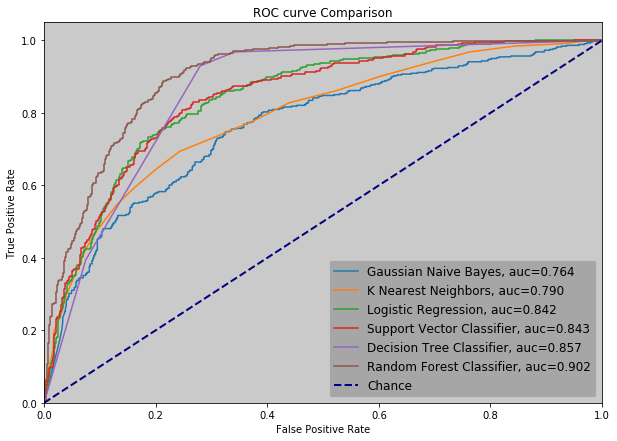

In [58]:
ROC_curve(y_score_lr, y_score_knn_half, y_score_svm, y_score_nb_half, y_score_dt_half, y_score_rf_half)

Text(0.5,1,'Grit vs. Conscientiousness')

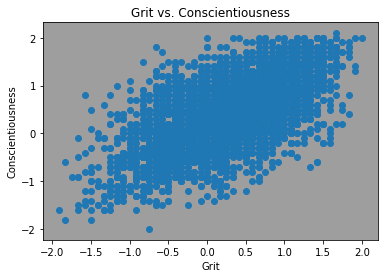

In [63]:
plt.scatter(df.Grit*(-1), df.Conscientiousness)
plt.xlabel('Grit')
plt.ylabel('Conscientiousness')
plt.title('Grit vs. Conscientiousness')

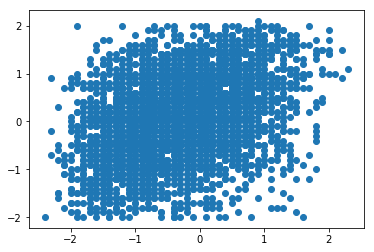

In [818]:
plt.scatter(df.Grit, df.Neuroticism)

In [118]:
PCAT_df = apply_PCA_LSA(df);

explained variance ratio: [0.16274781 0.09378011]
singular values: [237.78661172 180.50331455]
Components: [[ 1.11126919e-01 -1.14220986e-01 -1.16241658e-01  1.34203164e-01
  -1.61335348e-01  1.25237467e-01 -1.59278501e-01 -1.93754091e-01
   1.52159634e-01  1.71130631e-01 -5.75299061e-02  1.22615826e-01
  -9.85851445e-04 -8.03349722e-03 -9.60420105e-03 -2.23941846e-04
  -3.34732556e-03 -5.25509395e-03 -1.06682863e-02 -8.51967210e-03
  -3.13478924e-03 -1.40656725e-03 -4.16803199e-03 -3.96244012e-03
  -6.46829168e-03 -8.52995155e-03 -5.63424771e-04 -1.30619689e-04
   1.74086252e-02 -1.29423297e-01  1.22384665e-01 -1.79971169e-01
   1.50053905e-01 -1.64479768e-01  1.28054220e-01 -1.70856160e-01
   9.02994893e-02 -1.18400667e-01  1.55831416e-01  1.52828664e-01
  -9.34376981e-02  1.03428215e-01 -1.00721714e-01  1.50482000e-01
   1.67319562e-01  1.84031204e-01  1.93140050e-01  1.76242992e-01
   1.94356613e-01  8.18374175e-02 -1.00215735e-01  9.76218393e-02
  -5.95981494e-02  7.75710804e-02 -

In [119]:
PCAT_df

,0,1
I_have_overcome_setbacks_to_conquer_an_important_challenge_,0.111127,-0.009577
New_ideas_and_projects_sometimes_distract_me_from_previous_ones,-0.114221,-0.141174
My_interests_change_from_year_to_year,-0.116242,-0.130928
Setbacks_dont_discourage_me,0.134203,-0.002602
I_have_been_obsessed_with_a_certain_idea_or_project_for_a_short_time_but_later_lost_interest,-0.161335,-0.133667
I_am_a_hard_worker_,0.125237,0.062396
I_often_set_a_goal_but_later_choose_to_pursue_a_different_one,-0.159279,-0.135014
I_have_difficulty_maintaining_my_focus_on_projects_that_take_more_than_a_few_months_to_complete,-0.193754,-0.144249
I_finish_whatever_I_begin,0.152160,0.113945
I_have_achieved_a_goal_that_took_years_of_work,0.171131,0.060453


In [122]:
# Looking at the LR coefficients did not help at all 
LR_Coefficients()

Logistic Regression:
Cross Validated Accuracy Score: 0.7420003364612916
                               precision    recall  f1-score   support

          High school or less       0.77      0.79      0.78       629
University or Graduate degree       0.69      0.67      0.68       441

                  avg / total       0.74      0.74      0.74      1070



,Coefficients,Feature
0,-0.093121,I_have_overcome_setbacks_to_conquer_an_importa...
1,-0.061086,New_ideas_and_projects_sometimes_distract_me_f...
2,-0.021574,My_interests_change_from_year_to_year
3,0.115169,Setbacks_dont_discourage_me
4,0.041304,I_have_been_obsessed_with_a_certain_idea_or_pr...
5,0.087133,I_am_a_hard_worker_
6,-0.178715,I_often_set_a_goal_but_later_choose_to_pursue_...
7,0.157674,I_have_difficulty_maintaining_my_focus_on_proj...
8,0.018053,I_finish_whatever_I_begin
9,-0.327801,I_have_achieved_a_goal_that_took_years_of_work
